# Using machine learning to cluster probable leavers in order to develop retention strategies

In notebook 3., we built a model that predicted staff attrition with a 90% accuracy (92% precision, 90% recall).

In this notebook, we look to use KMeans clustering to group leaving employees based on common features, which we can then give to the business to develop any retention. We will also then visualise the key features that drive these clusters in order to provide business with insight that might be used to develop their retention strategy.

In [1]:
## Step 1 - Import necessary libraries
import pandas as pd
import sklearn


In [2]:
# Load cleaned data using an explicit relative path
df = pd.read_csv('../Data files/HR_Attrition_Cleaned.csv')

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           1470 non-null   int64  
 1   Attrition                     1470 non-null   object 
 2   BusinessTravel                1470 non-null   object 
 3   DailyRate                     1470 non-null   int64  
 4   Department                    1470 non-null   object 
 5   DistanceFromHome              1470 non-null   int64  
 6   Education                     1470 non-null   object 
 7   EducationField                1470 non-null   object 
 8   EnvironmentSatisfaction       1470 non-null   object 
 9   Gender                        1470 non-null   object 
 10  HourlyRate                    1470 non-null   int64  
 11  JobInvolvement                1470 non-null   object 
 12  JobLevel                      1470 non-null   int64  
 13  Job

### Clustering

Firstly we run KMeans to cluster employees in similar groupings. The code below is for 5 clusters, but images are also attached for the same code for 3 and 4 clusters, for comparison, as KMeans is a trial-and-error approach to determining optimal numbers of clusters.

In [4]:
#import content of SKLearn libraries needed for clustering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

# Step 1: Encode categorical variables
df_encoded = df.copy()
label_cols = df_encoded.select_dtypes(include=["object", "category"]).columns.drop("Attrition")
label_encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Step 2: Separate features and target
X_encoded = df_encoded.drop(columns=["Attrition"])
y = df["Attrition"]  # original string labels

# Step 3: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Step 4: Run KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Step 5: Create cluster DataFrame
cluster_df = pd.DataFrame(X_encoded)
cluster_df["Cluster"] = cluster_labels
cluster_df["Attrition"] = y.values

# Step 6: Profile clusters
cluster_summary = cluster_df.groupby("Cluster")["Attrition"].value_counts(normalize=True).unstack().fillna(0)
print(cluster_summary)

c:\Users\rache\.vscode\employee_attrition_analysis\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Attrition        No       Yes
Cluster                      
0          0.910000  0.090000
1          0.896296  0.103704
2          0.825581  0.174419
3          0.694969  0.305031
4          0.879070  0.120930


| K-Means clusters              | Outcomes                                      | Summary                          | 
|----------------------|------------------------------------------------------|--------------------------------------------------------|
| 3 cluster| <img src="KMeans 3 cluster.png" width="60%">| One group above average for total data set. Group1 is 'very safe  |
| 4 cluster|  <img src="KMeans 4 cluster.png" width="50%">| Two groups above average for total data set |
| 5 cluster|  <img src="KMeans 5 cluster.png" width="60%">| Two groups above average for total data set |

Having run 3,4 and 5 cluster tests, 5 clusters gives us two groups which would be worth assessing for possible retention strategy in the Yes group (dataset average for attrition is 16.1%). While 4 clusters also gives us two groups, the 5-cluster grouping will be slightly more tailored by virtue of the additional split.

Group3 contains 30% employees who leave, and group2 is made up of 17% leavers. So Group3 is our highest priority but no harm considering a strategy for Group2 who are marginally above average.

Now we need to look at what common features cause these groups to be clustered together

In [10]:
# Step 1: Identify high-risk clusters based on attrition proportions
attrition_summary = (
    cluster_df.groupby("Cluster")["Attrition"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

# Threshold-based selection (adjustable)
high_risk_cluster_ids = attrition_summary.query("Yes >= 0.17").index.tolist()

# Step 2: Filter cluster_df to high-risk clusters
high_risk_clusters = cluster_df[cluster_df["Cluster"].isin(high_risk_cluster_ids)]

# Step 3: Compute dataset-wide averages (numeric features only)
numeric_features = cluster_df.select_dtypes(include=["int64", "float64"]).columns.drop("Cluster", errors="ignore")
dataset_avg = pd.DataFrame(cluster_df[numeric_features].mean(), columns=["Dataset_Avg"])

# Step 4: Compute cluster-wise averages for high-risk clusters
cluster_avg = (
    high_risk_clusters.groupby("Cluster")[numeric_features]
    .mean()
    .T  # transpose for readability
)

# Step 5: Concatenate for comparison
comparison_table = pd.concat([cluster_avg, dataset_avg], axis=1)
comparison_table = comparison_table.round(3)  # optional: round for readability

# Display
print("📊 Feature Averages: High-Risk Clusters vs Dataset\n")
print(comparison_table)

📊 Feature Averages: High-Risk Clusters vs Dataset

                                      2          3  Dataset_Avg
Age                              35.564     29.755       36.924
DailyRate                       795.291    811.503      802.486
DistanceFromHome                  9.959      8.503        9.193
HourlyRate                       65.186     66.585       65.891
JobLevel                          1.709      1.280        2.064
MonthlyIncome                  4889.052   3455.443     6502.931
MonthlyRate                   13820.233  14676.129    14313.103
NumCompaniesWorked                2.483      1.717        2.693
PercentSalaryHike                21.715     14.632       15.210
StockOptionLevel                  0.843      0.642        0.794
TotalWorkingYears                 9.250      4.101       11.280
TrainingTimesLastYear             2.767      2.868        2.799
YearsAtCompany                    6.227      2.516        7.008
YearsInCurrentRole                4.273      1.248   

So this shows us the average for each cluster plus the average for the data set as a whole. We can present this as a heatmap, but we need to normalise the data first, otherwise higher absolute value numbers (e.g. income) will overshadow lower numbers (e.g. age), even if they're more relevant to the cluster.

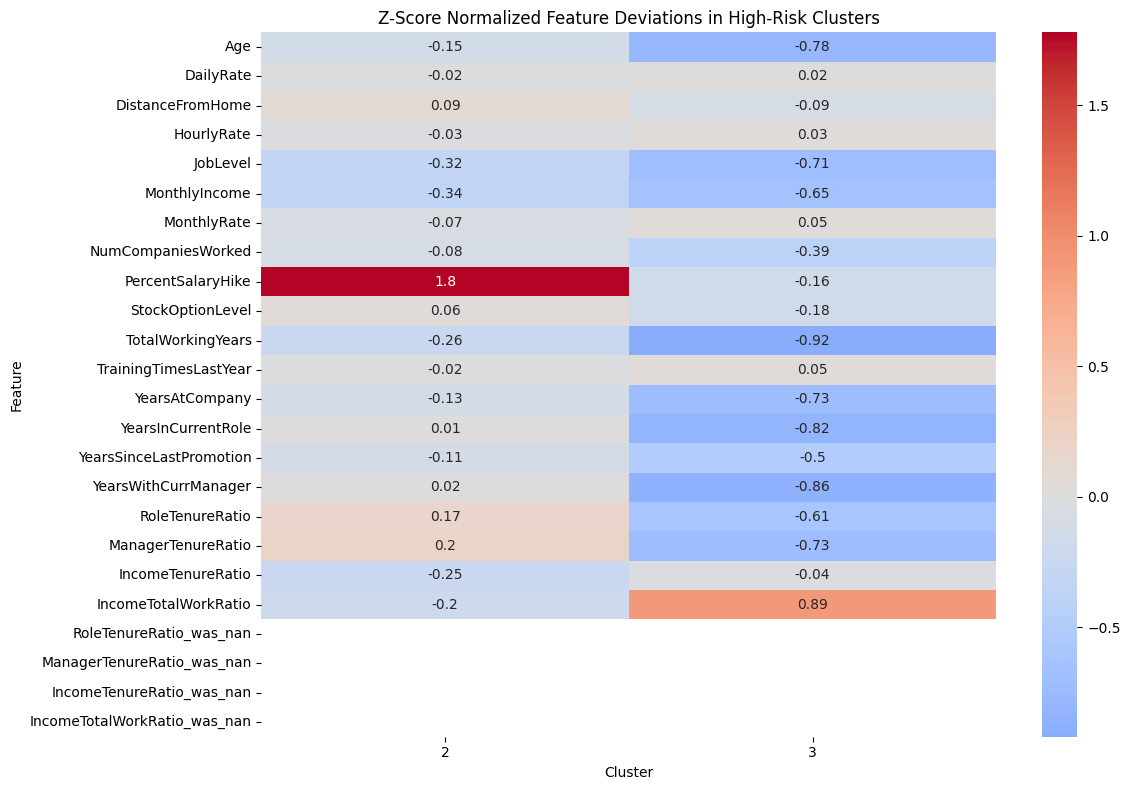

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Identify high-risk clusters based on attrition proportions
attrition_summary = (
    cluster_df.groupby("Cluster")["Attrition"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)
high_risk_cluster_ids = attrition_summary.query("Yes >= 0.17").index.tolist()

# Step 2: Filter cluster_df to high-risk clusters
high_risk_clusters = cluster_df[cluster_df["Cluster"].isin(high_risk_cluster_ids)]

# Step 3: Compute dataset-wide averages and standard deviations
numeric_features = cluster_df.select_dtypes(include=["int64", "float64"]).columns.drop("Cluster", errors="ignore")
dataset_avg = cluster_df[numeric_features].mean()
dataset_std = cluster_df[numeric_features].std()

# Step 4: Compute cluster-wise averages
cluster_avg = (
    high_risk_clusters.groupby("Cluster")[numeric_features]
    .mean()
    .T  # transpose for readability
)

# Step 5: Compute z-score normalized deviations
# Convert Series to DataFrame for broadcasting
dataset_avg_df = dataset_avg.to_frame(name="Dataset_Avg")
dataset_std_df = dataset_std.to_frame(name="Dataset_Std")

# Align and broadcast
normalized_deltas = (cluster_avg - dataset_avg_df.values) / dataset_std_df.values
normalized_deltas = pd.DataFrame(normalized_deltas, index=cluster_avg.index, columns=cluster_avg.columns)
normalized_deltas = normalized_deltas.round(2)

# Step 6: Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_deltas, annot=True, cmap="coolwarm", center=0)
plt.title("Z-Score Normalized Feature Deviations in High-Risk Clusters")
plt.ylabel("Feature")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

Before we recommend features to address for a segementation strategy, we should also look at the categorical values for these two clusters. We know from our previous visualisations that single employees are more likely to leave, so we should overlay those other features on our clusters.

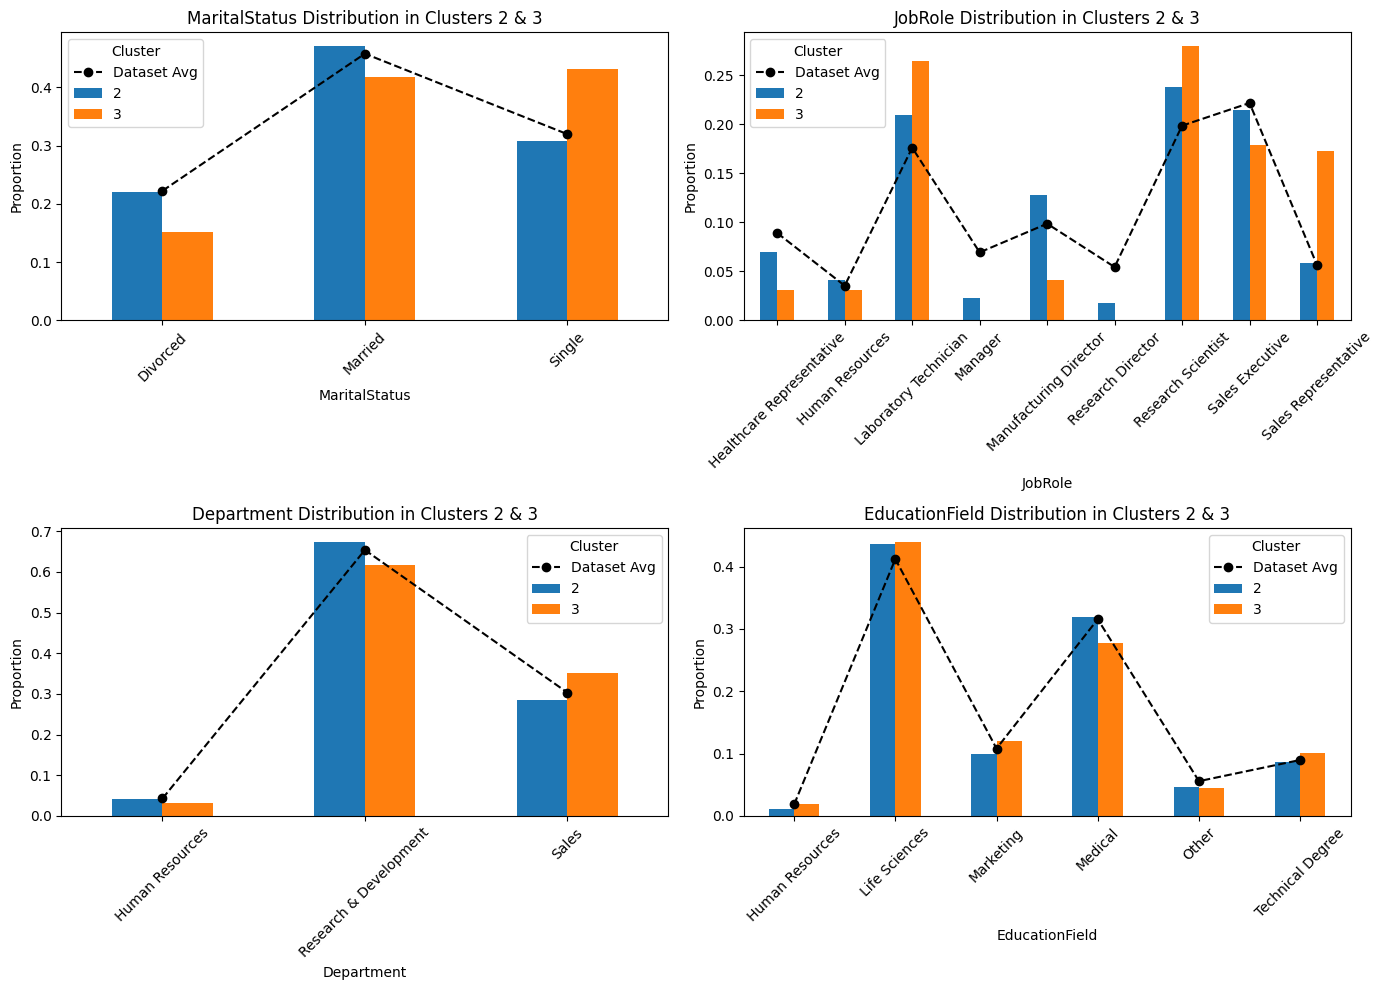

In [17]:
import matplotlib.pyplot as plt

# Step 1: Merge cluster labels back to original data
df_with_clusters = df.copy()
df_with_clusters["Cluster"] = cluster_df["Cluster"]

# Step 2: Filter to high-risk clusters
cluster_cats = df_with_clusters[df_with_clusters["Cluster"].isin([2, 3])]

# Step 3: Define categorical columns to plot
cat_cols = ["MaritalStatus", "JobRole", "Department", "EducationField"]

# Step 4: Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    # Dataset-wide proportions
    dataset_props = (
        df[col].value_counts(normalize=True)
        .sort_index()
    )

    # Cluster-specific proportions
    cluster_props = (
        cluster_cats.groupby(["Cluster", col])
        .size()
        .unstack(fill_value=0)
        .apply(lambda x: x / x.sum(), axis=1)
        .T
        .sort_index()
    )

    # Align categories
    all_categories = sorted(set(dataset_props.index).union(cluster_props.index))
    dataset_props = dataset_props.reindex(all_categories, fill_value=0)
    cluster_props = cluster_props.reindex(all_categories)

    # Plot bars
    cluster_props.plot(kind="bar", ax=axes[i])
    axes[i].plot(dataset_props.values, color="black", linestyle="--", marker="o", label="Dataset Avg")

    axes[i].set_title(f"{col} Distribution in Clusters 2 & 3")
    axes[i].set_ylabel("Proportion")
    axes[i].set_xlabel(col)
    axes[i].legend(title="Cluster")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

We also know from our visualisation notebook that commutes over >10 miles have a higher attrition level, and while this doesn't come out in the heatmap, this may simply be because it doesn't differ between the groups across all commute distances.

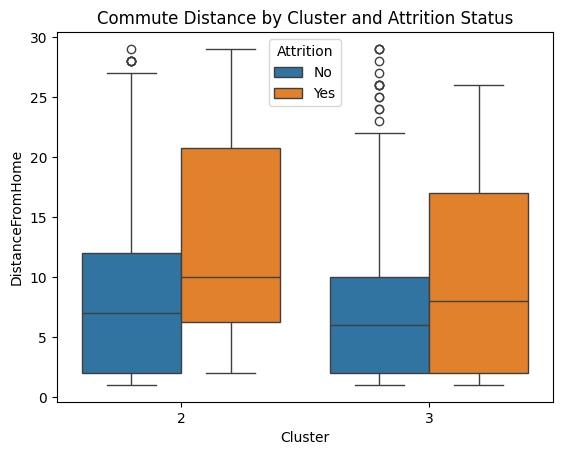

In [18]:
sns.boxplot(data=df_with_clusters[df_with_clusters["Cluster"].isin([2, 3])],
            x="Cluster", y="DistanceFromHome", hue="Attrition")
plt.title("Commute Distance by Cluster and Attrition Status")
plt.show()

So to determine if this is a predictor of attrition ,we should assess commutes >10 miles against <10 miles for the staff who've left.

In [21]:
#subset and compare attrition rates for longer commutes
long_commute = df[df["DistanceFromHome"] > 10]
attrition_rate = long_commute["Attrition"].value_counts(normalize=True)
print(attrition_rate)

Attrition
No     0.790541
Yes    0.209459
Name: proportion, dtype: float64


So slightly more of the Yes group have long commutes (data set has 16% attrition overall).

So we will check if attrition is a strong predictor for our retention strategy.

In [24]:
import ppscore
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pps = ppscore.score(long_commute, "DistanceFromHome", "Attrition")
print(f"PPS for long commutes: {pps['ppscore']:.2f}")

PPS for long commutes: 0.00


So a ppscore of 0.00 means commute distance can NOT be used as a predictor, despite its statistical significance.

So it can't be used in the model to PREDICT attrition but it remains a real-world factor that should be considered due to its significance.

### **Findings & recommendations**

Based on the above features for the two clusers, these would be the recommendations for consideration for staff retention:

**CLUSTER 2 - "High pay increase but disconnected"**

Key traits: High % payrise, yet still slightly lower in actual pay and job role level, higher proportion of married/divorced employees

This group has received above-average salary increases, yet still shows high attrition. That suggests:
- Compensation alone isn’t solving retention
- These employees may feel undervalued in non-financial ways — recognition, growth, or connection

Company should address the non-financial element of employee engagement for employees that meet these criteria when flagged as potential attrition risk via the ML randomforest model. This may include a more structured career path, recognition programmes, job rotation/skills enhancement or mentoring.

**CLUSTER 3 - "Young and mobile"**

Key traits: below average in age, tenure, promotion and manager engagement scores. Overrepresented in Sales roles, tend to be single.

This group is younger and so have less experience/training than their peers. It is possible that they feel undervalued and underpaid despite having less experience.

Company could look at initiatives to increase the sense of value for these groups to provide a sense of future opportunities for increased remuneration, to prevent job hopping for salart:
- developmental fast-track initiatves
- increased managerial coaching/engagement for younger employees
- social initiatives to increase team engagement tailored to younger single staff

Both clusters have a higher presence in two specific roles in the R&D department, so this would be a good place to focus any initial pilot of strategy.